# Pycox: DeepSurv Stratified by Batch


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchtuples as tt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

os.chdir("dl-survival-miRNA")
# os.chdir("../")
from pycox.models.cox import CoxPH, CoxPHStratified, StratifiedDataset
from pycox.evaluation.eval_surv import EvalSurv
from utils import *
from runDeepSurvModels import *

## *Test: Network*

In [26]:
from torch import Tensor

def cox_ph_loss_sorted(log_h: Tensor, events: Tensor, eps: float = 1e-7) -> Tensor:
    """Requires the input to be sorted by descending duration time.
    See DatasetDurationSorted.

    We calculate the negative log of $(\frac{h_i}{\sum_{j \in R_i} h_j})^d$,
    where h = exp(log_h) are the hazards and R is the risk set, and d is event.

    We just compute a cumulative sum, and not the true Risk sets. This is a
    limitation, but simple and fast.
    """
    if events.dtype is torch.bool:
        events = events.float()
    events = events.view(-1)
    log_h = log_h.view(-1)
    if events.sum() == 0:
        return log_h.sum() * 0.0  # update 08/11/25: safe dummy loss
    gamma = log_h.max()
    log_cumsum_h = log_h.sub(gamma).exp().cumsum(0).add(eps).log().add(gamma)
    return - log_h.sub(log_cumsum_h).mul(events).sum().div(events.sum())

####### [UPDATE] 1105
def stratified_cox_ph_loss(log_h: Tensor, durations: Tensor, events: Tensor, batch_indices: Tensor, eps: float = 1e-7) -> Tensor:
    """
    Stratified CoxPH loss that computes partial likelihood across batches.

    Arguments:
        log_h {torch.Tensor} -- Log hazard predictions for each instance.
        durations {torch.Tensor} -- Duration times for each instance.
        events {torch.Tensor} -- Event indicators (1 if event, 0 if censored).
        batch_indices {numpy array} -- Batch labels for each instance.
        eps {float} -- Small epsilon for numerical stability.

    Returns:
        torch.Tensor -- The total stratified negative log partial likelihood.
    """
    device = batch_indices.device
    unique_batches = torch.unique(batch_indices)
    losses = torch.zeros(len(unique_batches), device=device)
        
    for i, batch in enumerate(unique_batches):
        # Select data for the current batch
        mask = (batch_indices == batch)
        if mask.sum() == 0 or events[mask].sum() == 0:
            continue  # skip empty batch (added 08/11/25) or batch with no events
        
        # Sort by descending durations
        idx = torch.argsort(durations[mask], descending=True)
        
        events_batch = events[mask][idx]
        log_h_batch = log_h[mask][idx]
        if events_batch.sum() == 0:
            continue 
        
    #     losses[i] = cox_ph_loss_sorted(log_h_batch, events_batch, eps)
    
    # return losses.sum()
        losses[i] = cox_ph_loss_sorted(log_h_batch, events_batch, eps)
    
    total_loss = losses.sum()
    return total_loss if total_loss.requires_grad else log_h.sum() * 0.0


import torchtuples.callbacks as cb

### UPDATE 11/05
class CoxPHLossStratified(torch.nn.Module):
    """Loss for CoxPH model with batch variable.

    We calculate the batch-stratified negative log of $(\frac{h_i}{\sum_{j \in R_i} h_j})^d$,
    where h = exp(log_h) are the hazards and R is the risk set, and d is event.

    We just compute a cumulative sum, and not the true Risk sets. This is a
    limitation, but simple and fast.
    """
    # def forward(self, log_h: Tensor, durations: Tensor, events: Tensor, batch_indices: Tensor) -> Tensor:
        # return stratified_cox_ph_loss(log_h, durations, events, batch_indices)
    def forward(self, log_h: Tensor, durations: Tensor, events: Tensor, batch_indices: Tensor) -> Tensor:
        if torch.isnan(log_h).any():
            print("NaNs detected in log hazards")
        if torch.isnan(durations).any():
            print("NaNs detected in input survival time")
        if torch.isnan(events).any():
            print("NaNs detected in input events")
        if (events.sum() == 0).item():
            print("No observed events in batch (val)")
        return stratified_cox_ph_loss(log_h, durations, events, batch_indices)

In [ ]:
# import warnings

# # Import the entire base module
# from pycox.models import base
# from pycox.models import loss as Loss
# from pycox.models import utils

# def search_sorted_idx(array, values):
#     '''For sorted array, get index of values.
#     If value not in array, give left index of value.
#     '''
#     n = len(array)
#     idx = np.searchsorted(array, values)
#     idx[idx == n] = n-1 # We can't have indexes higher than the length-1
#     not_exact = values != array[idx]
#     idx -= not_exact
#     if any(idx < 0):
#         warnings.warn('Given value smaller than first value')
#         idx[idx < 0] = 0
#     return idx


# class _CoxBase(base.SurvBase):
#     duration_col = 'duration'
#     event_col = 'event'

#     def fit(self, input, target, batch_size=256, epochs=1, callbacks=None, verbose=True,
#             num_workers=0, shuffle=True, metrics=None, val_data=None, val_batch_size=8224,
#             **kwargs):
#         """Fit  model with inputs and targets. Where 'input' is the covariates, and
#         'target' is a tuple with (durations, events).
        
#         Arguments:
#             input {np.array, tensor or tuple} -- Input x passed to net.
#             target {np.array, tensor or tuple} -- Target [durations, events]. 
        
#         Keyword Arguments:
#             batch_size {int} -- Elements in each batch (default: {256})
#             epochs {int} -- Number of epochs (default: {1})
#             callbacks {list} -- list of callbacks (default: {None})
#             verbose {bool} -- Print progress (default: {True})
#             num_workers {int} -- Number of workers used in the dataloader (default: {0})
#             shuffle {bool} -- If we should shuffle the order of the dataset (default: {True})
#             **kwargs are passed to 'make_dataloader' method.
    
#         Returns:
#             TrainingLogger -- Training log
#         """
#         self.training_data = tt.tuplefy(input, target)
#         return super().fit(input, target, batch_size, epochs, callbacks, verbose,
#                            num_workers, shuffle, metrics, val_data, val_batch_size,
#                            **kwargs)

#     def _compute_baseline_hazards(self, input, df, max_duration, batch_size, eval_=True, num_workers=0):
#         raise NotImplementedError

#     def target_to_df(self, target):
#         durations, events = tt.tuplefy(target).to_numpy()
#         df = pd.DataFrame({self.duration_col: durations, self.event_col: events}) 
#         return df

#     def compute_baseline_hazards(self, input=None, target=None, max_duration=None, sample=None, batch_size=8224,
#                                 set_hazards=True, eval_=True, num_workers=0):
#         """Computes the Breslow estimates form the data defined by `input` and `target`
#         (if `None` use training data).

#         Typically call
#         model.compute_baseline_hazards() after fitting.
        
#         Keyword Arguments:
#             input  -- Input data (train input) (default: {None})
#             target  -- Target data (train target) (default: {None})
#             max_duration {float} -- Don't compute estimates for duration higher (default: {None})
#             sample {float or int} -- Compute estimates of subsample of data (default: {None})
#             batch_size {int} -- Batch size (default: {8224})
#             set_hazards {bool} -- Set hazards in model object, or just return hazards. (default: {True})
        
#         Returns:
#             pd.Series -- Pandas series with baseline hazards. Index is duration_col.
#         """
#         if (input is None) and (target is None):
#             if not hasattr(self, 'training_data'):
#                 raise ValueError("Need to give a 'input' and 'target' to this function.")
#             input, target = self.training_data
#         df = self.target_to_df(target)#.sort_values(self.duration_col)
#         if sample is not None:
#             if sample >= 1:
#                 df = df.sample(n=sample)
#             else:
#                 df = df.sample(frac=sample)
#         input = tt.tuplefy(input).to_numpy().iloc[df.index.values]
#         base_haz = self._compute_baseline_hazards(input, df, max_duration, batch_size,
#                                                   eval_=eval_, num_workers=num_workers)
#         if set_hazards:
#             self.compute_baseline_cumulative_hazards(set_hazards=True, baseline_hazards_=base_haz)
#         return base_haz

#     def compute_baseline_cumulative_hazards(self, input=None, target=None, max_duration=None, sample=None,
#                                             batch_size=8224, set_hazards=True, baseline_hazards_=None,
#                                             eval_=True, num_workers=0):
#         """See `compute_baseline_hazards. This is the cumulative version."""
#         if ((input is not None) or (target is not None)) and (baseline_hazards_ is not None):
#             raise ValueError("'input', 'target' and 'baseline_hazards_' can not both be different from 'None'.")
#         if baseline_hazards_ is None:
#             baseline_hazards_ = self.compute_baseline_hazards(input, target, max_duration, sample, batch_size,
#                                                              set_hazards=False, eval_=eval_, num_workers=num_workers)
#         assert baseline_hazards_.index.is_monotonic_increasing,\
#             'Need index of baseline_hazards_ to be monotonic increasing, as it represents time.'
#         bch = (baseline_hazards_
#                 .cumsum()
#                 .rename('baseline_cumulative_hazards'))
#         if set_hazards:
#             self.baseline_hazards_ = baseline_hazards_
#             self.baseline_cumulative_hazards_ = bch
#         return bch

#     def predict_cumulative_hazards(self, input, max_duration=None, batch_size=8224, verbose=False,
#                                    baseline_hazards_=None, eval_=True, num_workers=0):
#         """See `predict_survival_function`."""
#         if type(input) is pd.DataFrame:
#             input = self.df_to_input(input)
#         if baseline_hazards_ is None:
#             if not hasattr(self, 'baseline_hazards_'):
#                 raise ValueError('Need to compute baseline_hazards_. E.g run `model.compute_baseline_hazards()`')
#             baseline_hazards_ = self.baseline_hazards_
#         assert baseline_hazards_.index.is_monotonic_increasing,\
#             'Need index of baseline_hazards_ to be monotonic increasing, as it represents time.'
#         return self._predict_cumulative_hazards(input, max_duration, batch_size, verbose, baseline_hazards_,
#                                                 eval_, num_workers=num_workers)

#     def _predict_cumulative_hazards(self, input, max_duration, batch_size, verbose, baseline_hazards_,
#                                     eval_=True, num_workers=0):
#         raise NotImplementedError

#     def predict_surv_df(self, input, max_duration=None, batch_size=8224, verbose=False, baseline_hazards_=None,
#                         eval_=True, num_workers=0):
#         """Predict survival function for `input`. S(x, t) = exp(-H(x, t))
#         Require computed baseline hazards.

#         Arguments:
#             input {np.array, tensor or tuple} -- Input x passed to net.

#         Keyword Arguments:
#             max_duration {float} -- Don't compute estimates for duration higher (default: {None})
#             batch_size {int} -- Batch size (default: {8224})
#             baseline_hazards_ {pd.Series} -- Baseline hazards. If `None` used `model.baseline_hazards_` (default: {None})
#             eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
#             num_workers {int} -- Number of workers in created dataloader (default: {0})

#         Returns:
#             pd.DataFrame -- Survival estimates. One columns for each individual.
#         """
#         return np.exp(-self.predict_cumulative_hazards(input, max_duration, batch_size, verbose, baseline_hazards_,
#                                                        eval_, num_workers))

#     def predict_surv(self, input, max_duration=None, batch_size=8224, numpy=None, verbose=False,
#                      baseline_hazards_=None, eval_=True, num_workers=0):
#         """Predict survival function for `input`. S(x, t) = exp(-H(x, t))
#         Require compueted baseline hazards.

#         Arguments:
#             input {np.array, tensor or tuple} -- Input x passed to net.

#         Keyword Arguments:
#             max_duration {float} -- Don't compute estimates for duration higher (default: {None})
#             batch_size {int} -- Batch size (default: {8224})
#             numpy {bool} -- 'False' gives tensor, 'True' gives numpy, and None give same as input
#                 (default: {None})
#             baseline_hazards_ {pd.Series} -- Baseline hazards. If `None` used `model.baseline_hazards_` (default: {None})
#             eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
#             num_workers {int} -- Number of workers in created dataloader (default: {0})

#         Returns:
#             pd.DataFrame -- Survival estimates. One columns for each individual.
#         """
#         surv = self.predict_surv_df(input, max_duration, batch_size, verbose, baseline_hazards_,
#                                     eval_, num_workers)
#         surv = torch.from_numpy(surv.values.transpose())
#         return tt.utils.array_or_tensor(surv, numpy, input)

#     def save_net(self, path, **kwargs):
#         """Save self.net and baseline hazards to file.

#         Arguments:
#             path {str} -- Path to file.
#             **kwargs are passed to torch.save

#         Returns:
#             None
#         """
#         path, extension = os.path.splitext(path)
#         if extension == "":
#             extension = '.pt'
#         super().save_net(path+extension, **kwargs)
#         if hasattr(self, 'baseline_hazards_'):
#             self.baseline_hazards_.to_pickle(path+'_blh.pickle')

#     def load_net(self, path, **kwargs):
#         """Load net and hazards from file.

#         Arguments:
#             path {str} -- Path to file.
#             **kwargs are passed to torch.load

#         Returns:
#             None
#         """
#         path, extension = os.path.splitext(path)
#         if extension == "":
#             extension = '.pt'
#         super().load_net(path+extension, **kwargs)
#         blh_path = path+'_blh.pickle'
#         if os.path.isfile(blh_path):
#             self.baseline_hazards_ = pd.read_pickle(blh_path)
#             self.baseline_cumulative_hazards_ = self.baseline_hazards_.cumsum()

#     def df_to_input(self, df):
#         input = df[self.input_cols].values
#         return input
    

# class _CoxPHBase(_CoxBase):
#     def _compute_baseline_hazards(self, input, df_target, max_duration, batch_size, eval_=True, num_workers=0):
#         if max_duration is None:
#             max_duration = np.inf

#         # Here we are computing when expg when there are no events.
#         #   Could be made faster, by only computing when there are events.
#         return (df_target
#                 .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
#                 .groupby(self.duration_col)
#                 .agg({'expg': 'sum', self.event_col: 'sum'})
#                 .sort_index(ascending=False)
#                 .assign(expg=lambda x: x['expg'].cumsum())
#                 .pipe(lambda x: x[self.event_col]/x['expg'])
#                 .fillna(0.)
#                 .iloc[::-1]
#                 .loc[lambda x: x.index <= max_duration]
#                 .rename('baseline_hazards'))

#     def _predict_cumulative_hazards(self, input, max_duration, batch_size, verbose, baseline_hazards_,
#                                     eval_=True, num_workers=0):
#         max_duration = np.inf if max_duration is None else max_duration
#         if baseline_hazards_ is self.baseline_hazards_:
#             bch = self.baseline_cumulative_hazards_
#         else:
#             bch = self.compute_baseline_cumulative_hazards(set_hazards=False, 
#                                                            baseline_hazards_=baseline_hazards_)
#         bch = bch.loc[lambda x: x.index <= max_duration]
#         expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
#         return pd.DataFrame(bch.values.reshape(-1, 1).dot(expg), 
#                             index=bch.index)

#     def partial_log_likelihood(self, input, target, g_preds=None, batch_size=8224, eps=1e-7, eval_=True,
#                                num_workers=0):
#         '''Calculate the partial log-likelihood for the events in datafram df.
#         This likelihood does not sample the controls.
#         Note that censored data (non events) does not have a partial log-likelihood.

#         Arguments:
#             input {tuple, np.ndarray, or torch.tensor} -- Input to net.
#             target {tuple, np.ndarray, or torch.tensor} -- Target labels.

#         Keyword Arguments:
#             g_preds {np.array} -- Predictions from `model.predict` (default: {None})
#             batch_size {int} -- Batch size (default: {8224})
#             eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
#             num_workers {int} -- Number of workers in created dataloader (default: {0})

#         Returns:
#             Partial log-likelihood.
#         '''
#         df = self.target_to_df(target)
#         if g_preds is None:
#             g_preds = self.predict(input, batch_size, True, eval_, num_workers=num_workers)
#         return (df
#                 .assign(_g_preds=g_preds)
#                 .sort_values(self.duration_col, ascending=False)
#                 .assign(_cum_exp_g=(lambda x: x['_g_preds']
#                                     .pipe(np.exp)
#                                     .cumsum()
#                                     .groupby(x[self.duration_col])
#                                     .transform('max')))
#                 .loc[lambda x: x[self.event_col] == 1]
#                 .assign(pll=lambda x: x['_g_preds'] - np.log(x['_cum_exp_g'] + eps))
#                 ['pll'])


# class CoxPH(_CoxPHBase):
#     """Cox proportional hazards model parameterized with a neural net.
#     This is essentially the DeepSurv method [1].

#     The loss function is not quite the partial log-likelihood, but close.    
#     The difference is that for tied events, we use a random order instead of 
#     including all individuals that had an event at that point in time.

#     Arguments:
#         net {torch.nn.Module} -- A pytorch net.
    
#     Keyword Arguments:
#         optimizer {torch or torchtuples optimizer} -- Optimizer (default: {None})
#         device {str, int, torch.device} -- Device to compute on. (default: {None})
#             Preferably pass a torch.device object.
#             If 'None': use default gpu if available, else use cpu.
#             If 'int': used that gpu: torch.device('cuda:<device>').
#             If 'string': string is passed to torch.device('string').

#     [1] Jared L. Katzman, Uri Shaham, Alexander Cloninger, Jonathan Bates, Tingting Jiang, and Yuval Kluger.
#         Deepsurv: personalized treatment recommender system using a Cox proportional hazards deep neural network.
#         BMC Medical Research Methodology, 18(1), 2018.
#         https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1
#     """
#     def __init__(self, net, optimizer=None, device=None, loss=None):
#         if loss is None:
#             loss = Loss.CoxPHLoss()
#         super().__init__(net, loss, optimizer, device)

# ### Update 7/1/2025
# class StratifiedDataset(torch.utils.data.Dataset):
#     def __init__(self, x, durations, events, batch_ids):
#         self.x = x
#         self.durations = durations
#         self.events = events
#         self.batch_ids = batch_ids

#     def __len__(self):
#         return len(self.x)

#     def __getitem__(self, idx):
#         return self.x[idx], self.durations[idx], self.events[idx], self.batch_ids[idx]


# ### UPDATE 11/05/2024
# class CoxPHStratified(_CoxPHBase):
#     """Cox proportional hazards model parameterized with a neural net.

#     The loss function is not quite the partial log-likelihood, but close.    
#     The difference is that for we stratify events by batch (strata) when
#     calculating partial log likelihood.

#     Arguments:
#         net {torch.nn.Module} -- A pytorch net.
    
#     Keyword Arguments:
#         optimizer {torch or torchtuples optimizer} -- Optimizer (default: {None})
#         device {str, int, torch.device} -- Device to compute on. (default: {None})
#             Preferably pass a torch.device object.
#             If 'None': use default gpu if available, else use cpu.
#         loss {function} -- Loss function to use, default is stratified_cox_ph_loss.
#     """
#     def __init__(self, net, optimizer=None, device=None, loss=None):
#         self.batch_ids = None
#         if loss is None:
#             # loss = Loss.CoxPHLossStratified()
#             loss = CoxPHLossStratified()
#         super().__init__(net, loss, optimizer, device)
        
#     def compute_metrics(self, data, metrics=None):
#         if metrics is None:
#             metrics = self.metrics
#         if self.loss is None and self.loss in metrics.values():
#             raise RuntimeError("Need to set `self.loss`.")
#         x, durations, events, batch_ids = data
#         log_h = self.net(x)
        
#         if torch.isnan(log_h).any():
#             print("NaNs detected in log_h during compute_metrics()")
#             return {name: float('nan') for name in metrics}
        
#         return {name: metric(log_h, durations, events, batch_ids) for name, metric in metrics.items()}
    
#     def fit_dataloader(self, dataloader, epochs=1, callbacks=None, verbose=True, metrics=None, val_dataloader=None):
#         """
#         Custom training loop for CoxPHStratified that reads (x, duration, event, batch_id) from DataLoader.
        
#         Args:
#             dataloader (DataLoader): training data loader returning 4-tuples.
#             epochs (int): number of training epochs.
#             callbacks (list): optional callbacks.
#             verbose (bool): print training progress.
#             metrics (dict): optional metrics.
#             val_dataloader (DataLoader): optional validation dataloader (can be normal 2-tuple).
        
#         Returns:
#             TrainingLogger
#         """
#         self._setup_train_info(dataloader)
#         self.metrics = self._setup_metrics(metrics)
#         self.log.verbose = verbose
#         self.val_metrics.dataloader = val_dataloader
        
#         if callbacks is None:
#             callbacks = []
#         self.callbacks = cb.TrainingCallbackHandler(
#             self.optimizer, self.train_metrics, self.log, self.val_metrics, callbacks
#         )
#         self.callbacks.give_model(self)

#         stop = self.callbacks.on_fit_start()
#         for _ in range(epochs):
#             if stop:
#                 break
#             stop = self.callbacks.on_epoch_start()
#             if stop:
#                 break
            
#             for x, durations, events, batch_ids in dataloader:
#                 stop = self.callbacks.on_batch_start()
#                 if stop:
#                     break
                
#                 self.optimizer.zero_grad()
#                 log_h = self.net(x)
#                 loss = self.loss(log_h, durations, events, batch_ids)
#                 self.batch_loss = loss
#                 self.batch_metrics = {"loss": loss}
                
#                 loss.backward()
#                 stop = self.callbacks.before_step()
#                 if stop:
#                     break
#                 self.optimizer.step()
#                 stop = self.callbacks.on_batch_end()
#                 if stop:
#                     break
#             else:
#                 stop = self.callbacks.on_epoch_end()
#         self.callbacks.on_fit_end()
        
#         return self.log

In [56]:
import torch
import torchtuples as tt

# Import the entire base module
from pycox.models import base
from pycox.models import loss as Loss
from pycox.models import utils
import torchtuples.callbacks as cb


def search_sorted_idx(array, values):
    '''For sorted array, get index of values.
    If value not in array, give left index of value.
    '''
    n = len(array)
    idx = np.searchsorted(array, values)
    idx[idx == n] = n-1 # We can't have indexes higher than the length-1
    not_exact = values != array[idx]
    idx -= not_exact
    if any(idx < 0):
        warnings.warn('Given value smaller than first value')
        idx[idx < 0] = 0
    return idx


class _CoxBase(base.SurvBase):
    duration_col = 'duration'
    event_col = 'event'

    def fit(self, input, target, batch_size=256, epochs=1, callbacks=None, verbose=True,
            num_workers=0, shuffle=True, metrics=None, val_data=None, val_batch_size=8224,
            **kwargs):
        """Fit  model with inputs and targets. Where 'input' is the covariates, and
        'target' is a tuple with (durations, events).
        
        Arguments:
            input {np.array, tensor or tuple} -- Input x passed to net.
            target {np.array, tensor or tuple} -- Target [durations, events]. 
        
        Keyword Arguments:
            batch_size {int} -- Elements in each batch (default: {256})
            epochs {int} -- Number of epochs (default: {1})
            callbacks {list} -- list of callbacks (default: {None})
            verbose {bool} -- Print progress (default: {True})
            num_workers {int} -- Number of workers used in the dataloader (default: {0})
            shuffle {bool} -- If we should shuffle the order of the dataset (default: {True})
            **kwargs are passed to 'make_dataloader' method.
    
        Returns:
            TrainingLogger -- Training log
        """
        self.training_data = tt.tuplefy(input, target)
        return super().fit(input, target, batch_size, epochs, callbacks, verbose,
                           num_workers, shuffle, metrics, val_data, val_batch_size,
                           **kwargs)
    
    # [UPDATE 10/27] Add argument batch_id to allow different baseline hazard calculation for stratified NN 
    def _compute_baseline_hazards(self, input, df, batch_ids, max_duration, batch_size, eval_=True, num_workers=0):
        raise NotImplementedError

    def target_to_df(self, target):
        durations, events = tt.tuplefy(target).to_numpy()
        df = pd.DataFrame({self.duration_col: durations, self.event_col: events}) 
        return df

    def compute_baseline_hazards(self, input=None, target=None, batch_ids=None, max_duration=None, sample=None, batch_size=8224,
                                set_hazards=True, eval_=True, num_workers=0):
        """Computes the Breslow estimates form the data defined by `input` and `target`
        (if `None` use training data).

        Typically call
        model.compute_baseline_hazards() after fitting.
        
        Keyword Arguments:
            input  -- Input data (train input) (default: {None})
            target  -- Target data (train target) (default: {None})
            max_duration {float} -- Don't compute estimates for duration higher (default: {None})
            sample {float or int} -- Compute estimates of subsample of data (default: {None})
            batch_size {int} -- Batch size (default: {8224})
            set_hazards {bool} -- Set hazards in model object, or just return hazards. (default: {True})
        
        Returns:
            pd.Series -- Pandas series with baseline hazards. Index is duration_col.
        """
        if (input is None) and (target is None):
            if not hasattr(self, 'training_data'):
                raise ValueError("Need to give a 'input' and 'target' to this function.")
            input, target = self.training_data
            
        df = self.target_to_df(target)#.sort_values(self.duration_col)
        if sample is not None:
            if sample >= 1:
                df = df.sample(n=sample)
            else:
                df = df.sample(frac=sample)
                
        input = tt.tuplefy(input).to_numpy().iloc[df.index.values]
        # update 10/27: add batch ids
        batch_ids = batch_ids[df.index.values] if batch_ids is not None else np.repeat(1, len(df))
        base_haz = self._compute_baseline_hazards(input, df, batch_ids, max_duration, batch_size,
                                                  eval_=eval_, num_workers=num_workers)
        if set_hazards:
            self.compute_baseline_cumulative_hazards(set_hazards=True, baseline_hazards_=base_haz)
        return base_haz

    def compute_baseline_cumulative_hazards(self, input=None, target=None, batch_ids=None, max_duration=None, sample=None,
                                            batch_size=8224, set_hazards=True, baseline_hazards_=None,
                                            eval_=True, num_workers=0):
        """See `compute_baseline_hazards. This is the cumulative version."""
        
        if ((input is not None) or (target is not None)) and (baseline_hazards_ is not None):
            raise ValueError("'input', 'target' and 'baseline_hazards_' can not both be different from 'None'.")
        if baseline_hazards_ is None:
            baseline_hazards_ = self.compute_baseline_hazards(input, target, batch_ids, max_duration, sample, batch_size,
                                                             set_hazards=False, eval_=eval_, num_workers=num_workers)
        
        assert all([bh.index.is_monotonic_increasing for bh in baseline_hazards_.values()]),\
            'Need index of baseline_hazards_ to be monotonic increasing, as it represents time.'
            
        bch = {k: bh.cumsum().rename('baseline_cumulative_hazards') for k, bh in baseline_hazards_.items()}
        # bch = (baseline_hazards_
        #         .cumsum()
        #         .rename('baseline_cumulative_hazards'))
        
        if set_hazards:
            self.baseline_hazards_ = baseline_hazards_
            self.baseline_cumulative_hazards_ = bch
            
        return bch


    def predict_cumulative_hazards(self, input, batch_id=None, max_duration=None, batch_size=8224, verbose=False,
                                   baseline_hazards_=None, eval_=True, num_workers=0):
        """See `predict_survival_function`."""
        
        if type(input) is pd.DataFrame:
            input = self.df_to_input(input)
        if baseline_hazards_ is None:
            if not hasattr(self, 'baseline_hazards_'):
                raise ValueError('Need to compute baseline_hazards_. E.g run `model.compute_baseline_hazards()`')
            baseline_hazards_ = self.baseline_hazards_
            
        if batch_id is None:
            raise ValueError("Need to specify `batch_id` to select the correct baseline hazard")
        
        assert baseline_hazards_[batch_id].index.is_monotonic_increasing,\
            'Need index of baseline_hazards_ to be monotonic increasing, as it represents time.'
            
        return self._predict_cumulative_hazards(input, max_duration, batch_size, verbose, baseline_hazards_[batch_id],
                                                eval_, num_workers=num_workers)

    def _predict_cumulative_hazards(self, input, max_duration, batch_size, verbose, baseline_hazards_,
                                    eval_=True, num_workers=0):
        raise NotImplementedError

    def predict_surv_df(self, input, batch_id=None, max_duration=None, batch_size=8224, verbose=False, baseline_hazards_=None,
                        eval_=True, num_workers=0):
        """Predict survival function for `input`. S(x, t) = exp(-H(x, t))
        Require computed baseline hazards.

        Arguments:
            input {np.array, tensor or tuple} -- Input x passed to net.

        Keyword Arguments:
            max_duration {float} -- Don't compute estimates for duration higher (default: {None})
            batch_size {int} -- Batch size (default: {8224})
            baseline_hazards_ {pd.Series} -- Baseline hazards. If `None` used `model.baseline_hazards_` (default: {None})
            eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
            num_workers {int} -- Number of workers in created dataloader (default: {0})

        Returns:
            pd.DataFrame -- Survival estimates. One columns for each individual.
        """
        cum_haz = self.predict_cumulative_hazards(input, batch_id, max_duration, batch_size, verbose, baseline_hazards_,
                                                  eval_, num_workers)
        return np.exp(-cum_haz)

    def predict_surv(self, input, batch_id=None, max_duration=None, batch_size=8224, numpy=None, verbose=False,
                     baseline_hazards_=None, eval_=True, num_workers=0):
        """Predict survival function for `input`. S(x, t) = exp(-H(x, t))
        Require compueted baseline hazards.

        Arguments:
            input {np.array, tensor or tuple} -- Input x passed to net.

        Keyword Arguments:
            max_duration {float} -- Don't compute estimates for duration higher (default: {None})
            batch_size {int} -- Batch size (default: {8224})
            numpy {bool} -- 'False' gives tensor, 'True' gives numpy, and None give same as input
                (default: {None})
            baseline_hazards_ {pd.Series} -- Baseline hazards. If `None` used `model.baseline_hazards_` (default: {None})
            eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
            num_workers {int} -- Number of workers in created dataloader (default: {0})

        Returns:
            pd.DataFrame -- Survival estimates. One columns for each individual.
        """
        surv = self.predict_surv_df(input, batch_id, max_duration, batch_size, verbose, baseline_hazards_,
                                    eval_, num_workers)
        surv = torch.from_numpy(surv.values.transpose())
        return tt.utils.array_or_tensor(surv, numpy, input)

    def save_net(self, path, **kwargs):
        """Save self.net and baseline hazards to file.

        Arguments:
            path {str} -- Path to file.
            **kwargs are passed to torch.save

        Returns:
            None
        """
        path, extension = os.path.splitext(path)
        if extension == "":
            extension = '.pt'
        super().save_net(path+extension, **kwargs)
        if hasattr(self, 'baseline_hazards_'):
            self.baseline_hazards_.to_pickle(path+'_blh.pickle')

    def load_net(self, path, **kwargs):
        """Load net and hazards from file.

        Arguments:
            path {str} -- Path to file.
            **kwargs are passed to torch.load

        Returns:
            None
        """
        path, extension = os.path.splitext(path)
        if extension == "":
            extension = '.pt'
        super().load_net(path+extension, **kwargs)
        blh_path = path+'_blh.pickle'
        if os.path.isfile(blh_path):
            self.baseline_hazards_ = pd.read_pickle(blh_path)
            self.baseline_cumulative_hazards_ = self.baseline_hazards_.cumsum()

    def df_to_input(self, df):
        input = df[self.input_cols].values
        return input
    

class _CoxPHBase(_CoxBase):
    def _compute_baseline_hazards(self, input, df_target, batch_ids=None, max_duration=None,
                                  batch_size=8224, eval_=True, num_workers=0):
                                 # self, input, df_target, max_duration, batch_size, batch_ids=None, eval_=True, num_workers=0):
        if max_duration is None:
            max_duration = np.inf
            
        # Compute exp(log-risk)
        expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).flatten()
        df_target = df_target.assign(expg=expg)
        
        # --------------- Non-stratified version ----------------
        if batch_ids is None:
            # Here we are computing when expg when there are no events.
            #   Could be made faster, by only computing when there are events.
            return  (df_target
                        .groupby(self.duration_col)
                        .agg({'expg': 'sum', self.event_col: 'sum'})
                        .sort_index(ascending=False)
                        .assign(expg=lambda x: x['expg'].cumsum())
                        .pipe(lambda x: x[self.event_col] / x['expg'])
                        .fillna(0.)
                        .iloc[::-1]
                        .loc[lambda x: x.index <= max_duration]
                        .rename('baseline_hazards'))
        
        # ----------- Stratified version (per batch) ------------

        batch_ids = np.asarray(batch_ids)
        unique_batches = np.unique(batch_ids)
        baseline_hazards_dict = {}

        for b in unique_batches:
            mask = (batch_ids == b)
            df_b = df_target.loc[mask]
            if df_b[self.event_col].sum() == 0:
                continue  # skip strata with no events

            base_haz_b = (
                df_b.groupby(self.duration_col)
                    .agg({'expg': 'sum', self.event_col: 'sum'})
                    .sort_index(ascending=False)
                    .assign(expg=lambda x: x['expg'].cumsum())
                    .pipe(lambda x: x[self.event_col] / x['expg'])
                    .fillna(0.)
                    .iloc[::-1]
                    .loc[lambda x: x.index <= max_duration]
                    .rename(f'baseline_hazards_batch_{b}')
            )
            baseline_hazards_dict[b] = base_haz_b  

        return baseline_hazards_dict

    def _predict_cumulative_hazards(self, input, max_duration, batch_size, verbose, baseline_hazards_,
                                    eval_=True, num_workers=0):
        '''
        Predict cumulative hazard H(t|x) for either:
         - a single baseline hazard (non-stratified)
         - a batch-specific baseline_hazards_ (if baseline_hazards_ is a dict)
        '''
        max_duration = np.inf if max_duration is None else max_duration
        expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)

        # --------------- Non-stratified version ---------------
        if isinstance(baseline_hazards_, pd.Series):
            if baseline_hazards_ is self.baseline_hazards_:
                bch = self.baseline_cumulative_hazards_
            else:
                bch = self.compute_baseline_cumulative_hazards(set_hazards=False, 
                                                            baseline_hazards_=baseline_hazards_)
            bch = bch.loc[lambda x: x.index <= max_duration]
            expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
            return pd.DataFrame(bch.values.reshape(-1, 1).dot(expg), 
                                index=bch.index)
        
        # ----------- Stratified version (per batch) ------------
        elif isinstance(baseline_hazards_, dict):
            cumulative_hazards_dict = {}
            for b, haz in baseline_hazards_.items():
                bch = haz.cumsum().loc[lambda x: x.index <= max_duration]
                cumulative_hazards_dict[b] = pd.DataFrame(
                    bch.values.reshape(-1, 1).dot(expg), index=bch.index
                )
            return cumulative_hazards_dict

        else:
            raise ValueError("Invalid baseline_hazards_ type: expected pd.Series or dict of Series.")
        

    def partial_log_likelihood(self, input, target, g_preds=None, batch_size=8224, eps=1e-7, eval_=True,
                               num_workers=0):
        '''Calculate the partial log-likelihood for the events in datafram df.
        This likelihood does not sample the controls.
        Note that censored data (non events) does not have a partial log-likelihood.

        Arguments:
            input {tuple, np.ndarray, or torch.tensor} -- Input to net.
            target {tuple, np.ndarray, or torch.tensor} -- Target labels.

        Keyword Arguments:
            g_preds {np.array} -- Predictions from `model.predict` (default: {None})
            batch_size {int} -- Batch size (default: {8224})
            eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
            num_workers {int} -- Number of workers in created dataloader (default: {0})

        Returns:
            Partial log-likelihood.
        '''
        df = self.target_to_df(target)
        if g_preds is None:
            g_preds = self.predict(input, batch_size, True, eval_, num_workers=num_workers)
        return (df
                .assign(_g_preds=g_preds)
                .sort_values(self.duration_col, ascending=False)
                .assign(_cum_exp_g=(lambda x: x['_g_preds']
                                    .pipe(np.exp)
                                    .cumsum()
                                    .groupby(x[self.duration_col])
                                    .transform('max')))
                .loc[lambda x: x[self.event_col] == 1]
                .assign(pll=lambda x: x['_g_preds'] - np.log(x['_cum_exp_g'] + eps))
                ['pll'])


class CoxPH(_CoxPHBase):
    """Cox proportional hazards model parameterized with a neural net.
    This is essentially the DeepSurv method [1].

    The loss function is not quite the partial log-likelihood, but close.    
    The difference is that for tied events, we use a random order instead of 
    including all individuals that had an event at that point in time.

    Arguments:
        net {torch.nn.Module} -- A pytorch net.
    
    Keyword Arguments:
        optimizer {torch or torchtuples optimizer} -- Optimizer (default: {None})
        device {str, int, torch.device} -- Device to compute on. (default: {None})
            Preferably pass a torch.device object.
            If 'None': use default gpu if available, else use cpu.
            If 'int': used that gpu: torch.device('cuda:<device>').
            If 'string': string is passed to torch.device('string').

    [1] Jared L. Katzman, Uri Shaham, Alexander Cloninger, Jonathan Bates, Tingting Jiang, and Yuval Kluger.
        Deepsurv: personalized treatment recommender system using a Cox proportional hazards deep neural network.
        BMC Medical Research Methodology, 18(1), 2018.
        https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1
    """
    def __init__(self, net, optimizer=None, device=None, loss=None):
        if loss is None:
            loss = Loss.CoxPHLoss()
        super().__init__(net, loss, optimizer, device)


### Update 7/1/2025
class StratifiedDataset(torch.utils.data.Dataset):
    def __init__(self, x, durations, events, batch_ids):
        self.x = x
        self.durations = durations
        self.events = events
        self.batch_ids = batch_ids

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.durations[idx], self.events[idx], self.batch_ids[idx]

class CoxPHStratified(_CoxPHBase):
    """Cox proportional hazards model parameterized with a neural net.

    The loss function is not quite the partial log-likelihood, but close.    
    The difference is that for we stratify events by batch (strata) when
    calculating partial log likelihood.

    Arguments:
        net {torch.nn.Module} -- A pytorch net.
    
    Keyword Arguments:
        optimizer {torch or torchtuples optimizer} -- Optimizer (default: {None})
        device {str, int, torch.device} -- Device to compute on. (default: {None})
            Preferably pass a torch.device object.
            If 'None': use default gpu if available, else use cpu.
        loss {function} -- Loss function to use, default is stratified_cox_ph_loss.
    """
    def __init__(self, net, optimizer=None, device=None, loss=None):
        self.batch_ids = None
        if loss is None:
            loss = Loss.CoxPHLossStratified()
        super().__init__(net, loss, optimizer, device)
        
    def compute_metrics(self, data, metrics=None):
        if metrics is None:
            metrics = self.metrics
        if self.loss is None and self.loss in metrics.values():
            raise RuntimeError("Need to set `self.loss`.")
        x, durations, events, batch_ids = data
        log_h = self.net(x)
        
        if torch.isnan(log_h).any():
            print("NaNs detected in log_h during compute_metrics()")
            return {name: float('nan') for name in metrics}
        
        return {name: metric(log_h, durations, events, batch_ids) for name, metric in metrics.items()}
    
    def fit_dataloader(self, dataloader, epochs=1, callbacks=None, verbose=True, metrics=None, val_dataloader=None):
        """
        Custom training loop for CoxPHStratified that reads (x, duration, event, batch_id) from DataLoader.
        
        Args:
            dataloader (DataLoader): training data loader returning 4-tuples.
            epochs (int): number of training epochs.
            callbacks (list): optional callbacks.
            verbose (bool): print training progress.
            metrics (dict): optional metrics.
            val_dataloader (DataLoader): optional validation dataloader (can be normal 2-tuple).
        
        Returns:
            TrainingLogger
        """
        self._setup_train_info(dataloader)
        self.metrics = self._setup_metrics(metrics)
        self.log.verbose = verbose
        self.val_metrics.dataloader = val_dataloader
        
        if callbacks is None:
            callbacks = []
        self.callbacks = cb.TrainingCallbackHandler(
            self.optimizer, self.train_metrics, self.log, self.val_metrics, callbacks
        )
        self.callbacks.give_model(self)

        stop = self.callbacks.on_fit_start()
        for _ in range(epochs):
            if stop:
                break
            stop = self.callbacks.on_epoch_start()
            if stop:
                break
            
            for x, durations, events, batch_ids in dataloader:
                stop = self.callbacks.on_batch_start()
                if stop:
                    break
                
                self.optimizer.zero_grad()
                log_h = self.net(x)
                loss = self.loss(log_h, durations, events, batch_ids)
                self.batch_loss = loss
                self.batch_metrics = {"loss": loss}
                
                loss.backward()
                stop = self.callbacks.before_step()
                if stop:
                    break
                self.optimizer.step()
                stop = self.callbacks.on_batch_end()
                if stop:
                    break
            else:
                stop = self.callbacks.on_epoch_end()
        self.callbacks.on_fit_end()
        
        return self.log
    
    
    def predict_surv_df(self, input, batch_ids=None, max_duration=None,
                        batch_size=8224, verbose=False, baseline_hazards_=None,
                        eval_=True, num_workers=0):
        '''
        Predict survival curves. If stratified baselines have been computed,
        pass `batch_ids` (1D array-like, length = n_samples) to use the
        correct baseline hazard per stratum. Returns a pd.DataFrame of shape
        (time_grid x n_samples) with a common time index.

        Backward compatible:
        - If `batch_ids` is None and a single baseline (pd.Series) is stored, we
          fall back to _CoxBase.predict_surv_df behavior.
        - If baseline hazards are a dict (stratified) but batch_ids is None,
          we raise a clear error.
        '''
        
        if baseline_hazards_ is None:
            if not hasattr(self, 'baseline_hazards_'):
                raise ValueError("Need to compute baseline hazards. Run `model.compute_baseline_hazards(...)` first.")
            baseline_hazards_ = self.baseline_hazards_
            
        # -------- Non-stratified (use base implementation) ---------
        if isinstance(baseline_hazards_, pd.Series):
            
            return super().predict_surv_df(input, max_duration=max_duration,
                                           batch_size=batch_size, verbose=verbose,
                                           baseline_hazards_=baseline_hazards_,
                                           eval_=eval_, num_workers=num_workers)
        
        # Stratified: need batch_ids
        if not isinstance(baseline_hazards_, dict):
            raise ValueError("`baseline_hazards_` must be either a pd.Series or a dict of Series.")

        if batch_ids is None:
            raise ValueError("Stratified prediction requires `batch_ids` for each sample.")
        
        
        expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(-1)
        
        # Collect all survival times across batches
        all_times = None
        per_batch_surv = {}
        for b, haz in baseline_hazards_.items():
            bch = haz.cumsum()   # H_0,b(t)
            per_batch_surv[b] = bch   
            all_times = bch.index if all_times is None else all_times.union(bch.index)
        all_times = all_times.sort_values()

        # Fill in predicted survial along time grid
        out = np.empty((len(all_times), input.shape[0]), dtype=float)
        for b in np.unique(batch_ids):
            idx = np.where(batch_ids == b)[0]
            bch = per_batch_surv[b]
            # align H0b onto union grid with forward-fill
            H0b = bch.reindex(all_times, method='ffill').fillna(0.0).values
            # survival = exp(- H0_b(t) * exp(g(x)))
            out[:, idx] = np.exp(- np.outer(H0b, expg[idx]))
            
        return pd.DataFrame(out, index=all_times)

## *Test: Debugging*

In [5]:
# Create a PyTorch tensor
batch_indices = torch.tensor([1, 2, 2, 2, 2, 2, 3, 3, 4, 4], dtype=torch.float32)
durations = torch.tensor([169.5, 0.6, 12.3, 1.5, 3.8, 0.1, 0.1, 0.1, 0.6, 0.1], dtype=torch.float32)
events = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32)
log_h = torch.tensor([-4.1238, 2.1188, -1.5863, -1.2239, 0.9088, 5.6637, 1.2920, 4.5356, 1.5392, 5.0004], dtype=torch.float32)

# Test out ufnction
device = batch_indices.device
unique_batches = torch.unique(batch_indices)
losses = torch.zeros(len(unique_batches), device=device)

for i, batch in enumerate(unique_batches):
    # i = 1
    # batch = 1
    # print(i)
    mask = (batch_indices == batch)
    if mask.sum() == 0:
        print(f"batch {batch} is empty")
        continue
    idx = torch.argsort(durations[mask], descending=True)
    # idx = durations[mask].sort(descending=True)[1]
    log_h_batch = log_h[mask][idx]
    events_batch = events[mask][idx]
    
    print(events_batch)
    if events_batch.sum() == 0:
        print(f"batch {int(batch)} has no events")
        continue
    
    losses[i] = cox_ph_loss_sorted(log_h_batch, events_batch, eps=1e-7)
    
losses.sum()

tensor([0.])
batch 1 has no events
tensor([1., 1., 1., 1., 1.])
tensor([1., 1.])
tensor([1., 1.])


tensor(0.5826)

In [94]:
stratified_cox_ph_loss(log_h, durations, events, batch_indices)

tensor(0.5826)

# Full process

In [28]:
batchNormType='BE00Asso00_normTMM'
dataType = 'linear-moderate'
keywords = ['061825']
test_size=10000
random_state=42
time_col='time'
status_col='status'
batch_col='batch.id'

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataType,
                                                keywords=keywords, 
                                                keep_batch=True)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

Training data dimensions: (90000, 541)
Testing data dimensions:  (10000, 541)


In [62]:
def _preprocess_data(df, mapper=None, fit_scaler=True):
    survival_cols = [time_col, status_col]
    covariate_cols = [col for col in df.columns if col not in survival_cols]
    
    if fit_scaler or mapper is None:
        standardize = [([col], StandardScaler()) for col in covariate_cols]
        mapper = DataFrameMapper(standardize)
        # Transform features (miRNA expression)
        x = mapper.fit_transform(df[covariate_cols]).astype('float32')
    else:
        x = mapper.transform(df[covariate_cols]).astype('float32')
    
    # Prepare labels (survival data)
    y = (df[time_col].values, df[status_col].values)
    
    return x, y, mapper

train_sub,_ = train_test_split(train_df,
                            train_size=100, 
                            shuffle=True, random_state=42,
                            stratify=train_df[[status_col, batch_col]])
test_sub, _ = train_test_split(test_df,
                            train_size=1000, 
                            shuffle=True, random_state=42,
                            stratify=test_df[[status_col, batch_col]])

batch_ids_train = train_sub[batch_col].to_numpy().reshape(-1)
batch_ids_test = test_sub[[batch_col]].to_numpy().reshape(-1)

train_sub = train_sub.drop(columns=[batch_col])
test_sub = test_sub.drop(columns=[batch_col])

x_train, y_train, mapper = _preprocess_data(train_sub, fit_scaler=True)
x_test, y_test, _ = _preprocess_data(test_sub, mapper=mapper, fit_scaler=False)

durations_train, events_train = y_train[0], y_train[1]
durations_test, events_test = y_test[0], y_test[1]

# Prepare data 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(x_train).to(device)
x_test = torch.from_numpy(x_test).to(device)

durations_train = torch.from_numpy(durations_train).float().to(device)
durations_test = torch.from_numpy(durations_test).float().to(device)
events_train = torch.from_numpy(events_train).float().to(device)
events_test = torch.from_numpy(events_test).float().to(device)
y_train = (durations_train, events_train)
y_test = (durations_test, events_test)
        
batch_ids_train = torch.from_numpy(batch_ids_train).long().to(device)
batch_ids_test = torch.from_numpy(batch_ids_test).long().to(device)

print(x_test.shape)           # Should be [n_samples, n_features]
# print(y_test.shape)           # Should be [n_samples, n_features]
print(durations_test.shape)   # Should be [n_samples]
print(events_test.shape)      # Should be [n_samples]
print(batch_ids_test.shape)   # Should be [n_samples]

torch.Size([1000, 538])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [63]:
# x_train.shape
input_size = x_train.shape[1]
output_size = 1
num_nodes = [32]            # Default # layers & nodes
dropout = 0.3                    # Default dropout rate
learning_rate = 1e-4      # Default learning rate
batch_size = 128               # Default batch size
epochs = 500                      # Default number of epochs
batch_norm = True             # Default batch normalization
output_bias = True           # Default output bias
weight_decay = 1e-4         # Default weight decay
activation = torch.nn.ReLU

net = tt.practical.MLPVanilla(
    in_features=input_size,
    out_features=output_size,
    num_nodes=num_nodes,
    dropout=dropout, 
    batch_norm=batch_norm,
    activation=activation,
    output_bias=output_bias
).to(device)
optimizer = tt.optim.Adam(weight_decay=weight_decay, lr=learning_rate)

# Get default early stopping settings if not defined 
patience = 30
min_delta = 1e-3
callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]

### CoxPH

In [22]:
# CoxPH model
model = CoxPH(net, optimizer=optimizer)
log = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks, 
    verbose=True,
    val_data=(x_test, y_test),
    val_batch_size=batch_size
)

0:	[0s / 0s],		train_loss: 4.3518,	val_loss: 4.3259
1:	[0s / 0s],		train_loss: 4.3028,	val_loss: 4.3165
2:	[0s / 0s],		train_loss: 4.2858,	val_loss: 4.3062
3:	[0s / 0s],		train_loss: 4.2945,	val_loss: 4.2940
4:	[0s / 0s],		train_loss: 4.2453,	val_loss: 4.2832
5:	[0s / 0s],		train_loss: 4.2234,	val_loss: 4.2719
6:	[0s / 0s],		train_loss: 4.2215,	val_loss: 4.2619
7:	[0s / 0s],		train_loss: 4.1916,	val_loss: 4.2547
8:	[0s / 0s],		train_loss: 4.1704,	val_loss: 4.2461
9:	[0s / 0s],		train_loss: 4.1898,	val_loss: 4.2370
10:	[0s / 0s],		train_loss: 4.1650,	val_loss: 4.2294
11:	[0s / 0s],		train_loss: 4.1128,	val_loss: 4.2230
12:	[0s / 0s],		train_loss: 4.1064,	val_loss: 4.2139
13:	[0s / 0s],		train_loss: 4.1323,	val_loss: 4.2059
14:	[0s / 0s],		train_loss: 4.0793,	val_loss: 4.1999
15:	[0s / 0s],		train_loss: 4.1273,	val_loss: 4.1949
16:	[0s / 0s],		train_loss: 4.0771,	val_loss: 4.1894
17:	[0s / 0s],		train_loss: 4.0747,	val_loss: 4.1830
18:	[0s / 0s],		train_loss: 4.0386,	val_loss: 4.1779
19:

In [24]:
# ==================== Evaluation ====================
_ = model.compute_baseline_hazards(input=x_train, target=(durations_train, events_train))

# Convert torch tensors back to numpy objects for evaluation
x_train_np = x_train.detach().cpu().numpy()
x_test  = x_test.detach().cpu().numpy()
durations_train = durations_train.detach().cpu().numpy()
durations_test  = durations_test.detach().cpu().numpy()
events_train    = events_train.detach().cpu().numpy()
events_test     = events_test.detach().cpu().numpy()

# Initialize EvalSurv objects 
tr_surv  = model.predict_surv_df(x_train)
te_surv = model.predict_surv_df(x_test)
tr_ev = EvalSurv(tr_surv, durations_train, events_train, censor_surv='km')
te_ev = EvalSurv(te_surv, durations_test, events_test, censor_surv='km')

# Concordance index ----------------
tr_c_index  = tr_ev.concordance_td() 
te_c_index = te_ev.concordance_td() 

tr_c_index, te_c_index

(0.9043156991757367, 0.7466810320211219)

### Stratified CoxPH

In [56]:
# train_dataset = StratifiedDataset(x_train, durations_train, events_train, batch_ids_train)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataset = torch.utils.data.TensorDataset(x_test, durations_test, events_test, batch_ids_test)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# # # Access batches
# # for idx, (inputs, durations, events, batch_ids) in enumerate(train_loader):
# #     print(f"Batch {idx + 1}:")
# #     print("batch ids:", batch_ids)
# #     # print("Time:", durations)
# #     print("Events:", events)
# #     print()
    
# ## Test
# for idx, (inputs, durations, events, batch_ids) in enumerate(test_loader):
#     print(f"Batch {idx + 1}:")
#     print("batch ids:", batch_ids)
#     # print("Time:", durations)
#     print("Events:", events)
#     print()

In [64]:
# Get default early stopping settings if not defined 
patience = 30
min_delta = 1e-3
callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]

train_dataset = StratifiedDataset(x_train, durations_train, events_train, batch_ids_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataset = torch.utils.data.TensorDataset(x_test, durations_test, events_test, batch_ids_test)
test_dataset = StratifiedDataset(x_test, durations_test, events_test, batch_ids_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for xb, db, eb, bb in test_loader:
    print("VAL batch total events:", int(eb.sum().item()),
          "| per-stratum:", {int(s): int(eb[bb==s].sum().item()) for s in bb.unique().tolist()})


VAL batch total events: 95 | per-stratum: {1: 11, 2: 10, 3: 10, 4: 11, 5: 6, 6: 7, 7: 7, 8: 9, 9: 7, 10: 17}
VAL batch total events: 96 | per-stratum: {1: 13, 2: 9, 3: 11, 4: 8, 5: 7, 6: 6, 7: 9, 8: 11, 9: 10, 10: 12}
VAL batch total events: 103 | per-stratum: {1: 8, 2: 10, 3: 6, 4: 12, 5: 14, 6: 10, 7: 11, 8: 11, 9: 15, 10: 6}
VAL batch total events: 93 | per-stratum: {1: 13, 2: 11, 3: 11, 4: 7, 5: 4, 6: 10, 7: 11, 8: 6, 9: 8, 10: 12}
VAL batch total events: 94 | per-stratum: {1: 13, 2: 15, 3: 12, 4: 10, 5: 10, 6: 12, 7: 4, 8: 6, 9: 7, 10: 5}
VAL batch total events: 96 | per-stratum: {1: 8, 2: 9, 3: 7, 4: 13, 5: 15, 6: 8, 7: 11, 8: 5, 9: 12, 10: 8}
VAL batch total events: 94 | per-stratum: {1: 8, 2: 13, 3: 4, 4: 13, 5: 6, 6: 7, 7: 16, 8: 10, 9: 9, 10: 8}
VAL batch total events: 77 | per-stratum: {1: 11, 2: 3, 3: 6, 4: 10, 5: 8, 6: 12, 7: 6, 8: 9, 9: 5, 10: 7}


In [65]:
# Stratified CoxPH model
model = CoxPHStratified(net, optimizer=optimizer)
model.metrics = {'val_loss': model.loss}
start = time.time() # Record iteration start time
log = model.fit_dataloader(
    train_loader,
    epochs=epochs,
    callbacks=callbacks,
    verbose=True,
    val_dataloader=test_loader  # optional for now
)
stop = time.time() # Record time when training finished
duration = round(stop - start, 2)
print(f"Training time: {duration}")

0:	[0s / 0s],		train_loss: 20.2187,	val_loss: 20.7857
1:	[0s / 0s],		train_loss: 21.1249,	val_loss: 20.7570
2:	[0s / 0s],		train_loss: 20.6463,	val_loss: 20.7291
3:	[0s / 0s],		train_loss: 19.8060,	val_loss: 20.7010
4:	[0s / 0s],		train_loss: 20.2992,	val_loss: 20.6730
5:	[0s / 0s],		train_loss: 19.6286,	val_loss: 20.6453
6:	[0s / 0s],		train_loss: 20.1697,	val_loss: 20.6195
7:	[0s / 0s],		train_loss: 19.8592,	val_loss: 20.5934
8:	[0s / 0s],		train_loss: 18.9648,	val_loss: 20.5684
9:	[0s / 0s],		train_loss: 19.7056,	val_loss: 20.5443
10:	[0s / 0s],		train_loss: 19.6479,	val_loss: 20.5191
11:	[0s / 0s],		train_loss: 19.1118,	val_loss: 20.4953
12:	[0s / 0s],		train_loss: 18.3612,	val_loss: 20.4726
13:	[0s / 0s],		train_loss: 18.6101,	val_loss: 20.4497
14:	[0s / 0s],		train_loss: 18.3735,	val_loss: 20.4283
15:	[0s / 0s],		train_loss: 18.6332,	val_loss: 20.4065
16:	[0s / 0s],		train_loss: 18.5248,	val_loss: 20.3855
17:	[0s / 0s],		train_loss: 19.2007,	val_loss: 20.3646
18:	[0s / 0s],		trai

### Evaluation

In [66]:
# ==================== Evaluation ====================

# Convert torch tensors back to numpy objects for evaluation
x_train_np = x_train.detach().cpu().numpy()
x_test  = x_test.detach().cpu().numpy()
durations_train = durations_train.detach().cpu().numpy()
durations_test  = durations_test.detach().cpu().numpy()
events_train    = events_train.detach().cpu().numpy()
events_test     = events_test.detach().cpu().numpy()
batch_ids_train_np = batch_ids_train.detach().cpu().numpy()
batch_ids_test_np  = batch_ids_test.detach().cpu().numpy()


_ = model.compute_baseline_hazards(input=x_train, target=(durations_train, events_train), batch_ids=batch_ids_train_np)
# _ = model.compute_baseline_hazards(input=x_train, target=(durations_train, events_train))


# Initialize EvalSurv objects 
tr_surv  = model.predict_surv_df(x_train, batch_ids = batch_ids_train_np)
te_surv = model.predict_surv_df(x_test, batch_ids = batch_ids_test_np)
tr_ev = EvalSurv(tr_surv, durations_train, events_train, censor_surv='km')
te_ev = EvalSurv(te_surv, durations_test, events_test, censor_surv='km')

# Concordance index ----------------
tr_c_index, _  = tr_ev.concordance_td() 
te_c_index, _ = te_ev.concordance_td() 

print(tr_c_index, te_c_index)

0.9539973202322466 0.5688186143363602


#### *Test: Stratified C-index* 

In [70]:
# Concordance index ----------------
tr_strat_c_index  = tr_ev.stratified_concordance_td(batch_indices=batch_ids_train_np) 
te_strat_c_index = te_ev.stratified_concordance_td(batch_indices=batch_ids_test_np) 
print(tr_strat_c_index, te_strat_c_index)

0.9375 0.5930201580676672


In [23]:
# Manual test
from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import ipcw

batch_indices = batch_ids_train.detach().cpu().numpy() if not isinstance(batch_ids_train, np.ndarray) else batch_ids_train
batches = np.unique(batch_indices)
c_index_ls , n_pairs_ls = np.zeros(len(batches)), np.zeros(len(batches))

for i, batch in enumerate(batches):
    # Filter data by batch
    mask = (batch_indices == batch)
    if mask.sum() == 0:
        continue  # skip empty batch
    batch_durations = durations_train[mask]
    batch_events = events_train[mask]
    batch_surv = tr_ev.surv.iloc[:, mask]
    if batch_events.sum() == 0:
        continue
    
    # Compute concordance for the current batch
    c_index_batch, n_pairs_batch = concordance_td(
        batch_durations, batch_events, batch_surv.values,
        tr_ev.idx_at_times(batch_durations), method='adj_antolini'
    )
    print(n_pairs_batch)
    n_pairs_ls[i] = n_pairs_batch
    # n_events_ls[i] = batch_events.sum()
    c_index_ls[i] = c_index_batch
    
print("Final score: %f" % (np.sum(c_index_ls*n_pairs_ls) / np.sum(n_pairs_ls) if np.sum(n_pairs_ls) > 0 else float('nan')))

for e, c in zip(n_pairs_ls, c_index_ls):
    print(f"{int(e)} comparable pairs: {round(c,3)}")

1183.0
1164.0
1072.0
1169.0
1067.0
1129.0
1134.0
1043.0
1106.0
1047.0
Final score: 0.888879
1183 comparable pairs: 0.828
1164 comparable pairs: 0.836
1072 comparable pairs: 0.951
1169 comparable pairs: 0.875
1067 comparable pairs: 0.927
1129 comparable pairs: 0.88
1134 comparable pairs: 0.874
1043 comparable pairs: 0.944
1106 comparable pairs: 0.873
1047 comparable pairs: 0.917


#### *Test: Stratified Integrated Brier score*

In [68]:
# Integrated Brier score -----------
min_surv = np.ceil(max(np.min(durations_train), np.min(durations_test)))
max_surv = np.floor(min(np.max(durations_train), np.max(durations_test)))
times = np.linspace(min_surv, max_surv, 20)

tr_brier  = tr_ev.integrated_brier_score(time_grid=times) 
te_brier =  te_ev.integrated_brier_score(time_grid=times)

print(tr_brier, te_brier)

0.06839009323493692 0.18597674217719798


In [69]:
tr_strat_brier  = tr_ev.stratified_integrated_brier_score(time_grid=times, batch_indices=batch_ids_train) 
te_strat_brier =  te_ev.stratified_integrated_brier_score(time_grid=times, batch_indices=batch_ids_test)
print(tr_strat_brier, te_strat_brier)

0.06375763691975875 0.17991135049219684


In [ ]:
# print(tr_ev.surv.values.shape) 
# print(tr_ev.censor_surv.surv.values.shape)
# print(tr_ev.index_surv.shape)
# print(tr_ev.censor_surv.index_surv.shape) 
# print(tr_ev.steps)
# print(tr_ev.censor_surv.steps)

(500, 500)
(501, 500)
(500,)
(501,)
post
post


In [142]:
batch_indices = batch_ids_train.detach().numpy() if not isinstance(batch_ids_train, np.ndarray) else batch_ids_train
batches = np.unique(batch_indices)
brier_ls, n_events_ls = np.zeros(len(batches)), np.zeros(len(batches))

for i, batch in enumerate(batches):
    # Filter data by batch
    mask = (batch_indices == batch)
    if mask.sum() == 0:
        continue  # skip empty batch
    batch_durations = durations_train[mask]
    batch_events = events_train[mask]
    batch_surv = tr_ev.surv.iloc[:, mask]
    if batch_events.sum() == 0:
        continue
    batch_surv_values = tr_ev.surv.values[:, mask]
    batch_censor_surv_values = tr_ev.censor_surv.surv.values[:, mask] 
    # batch_index_surv = tr_ev.index_surv[mask]
    # batch_censor_index_surv = tr_ev.censor_surv.index_surv[mask]
    
    # Compute integrated brier score for the current batch
    brier_batch = ipcw.integrated_brier_score(times, batch_durations, batch_events, 
                                    batch_surv_values, batch_censor_surv_values, 
                                    tr_ev.index_surv, tr_ev.censor_surv.index_surv, np.inf, 
                                    tr_ev.steps, tr_ev.censor_surv.steps)
    n_events_ls[i] = batch_events.sum()
    brier_ls[i] = brier_batch
    
print("Final score: %f\n" % (np.sum(brier_ls*n_events_ls) / np.sum(n_events_ls) if np.sum(n_events_ls) > 0 else float('nan')))

for e, c in zip(n_events_ls, brier_ls):
    print(f"{int(e)} events: {round(c,3)}")

Final score: 0.066540

42 events: 0.083
40 events: 0.044
33 events: 0.03
43 events: 0.046
36 events: 0.054
37 events: 0.117
38 events: 0.091
33 events: 0.081
37 events: 0.059
37 events: 0.06


# Pipeline Test

Training data dimensions: (90000, 541)
Testing data dimensions:  (10000, 541)
Event rate in train set: 0.754811
Event rate in test set: 0.751200
Survival time distribution:


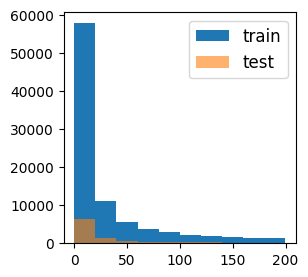

In [2]:
# Load data
batchNormType='BE00Asso00_normNone'
dataName='nl-shiftquad'
keywords = ['061825']
test_size=10000
random_state=42
time_col='time'
status_col='status'
batch_col='batch.id'

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                keep_batch=True)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
plot_simulation_data(train_df, test_df)

In [ ]:
hyperparameters = {
    "num_nodes": {"type": "categorical", "choices": [[64,64], [32,32], [16,16]]},
    "dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "batch_size": {"type": "categorical", "choices": [128, 64, 32, 16]}
}

ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters,
    is_stratified=True
)

# optuna.logging.disable_default_handler()
stratified_results = ds.train_over_subsets(subset_sizes=[2000],#subset_sizes, 
                                runs_per_size=[5],#runs_per_size, 
                                splits_per_size=[10],#splits_per_size,
                                trials_per_size=[5],#trails_per_size,
                                is_tune=True, 
                                is_save=False, 
                                n_jobs=-1,
                                trial_threshold=5                               
)
stratified_results

Running for N=2000...


[I 2025-07-15 16:16:32,713] Using an existing study with name 'BE00Asso00_normNone-nl-shiftquad-2000' instead of creating a new one.
/home/nfs/dengy/dl-surv/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
/home/nfs/dengy/dl-surv/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32, 32] which is of type list.
  warnings.warn(message)
/home/nfs/dengy/dl-surv/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
  warnings.warn(message)


All hyperparameters already tuned: {'num_nodes': [32, 32], 'dropout': 0.3982553088141435, 'weight_decay': 6.601169046362002e-05, 'learning_rate': 0.0007099041822497433, 'batch_size': 16}
Skipping optimization...
(Avg. runtime: 16.47s)   |                (C-index)  Train: 0.768, Test: 0.638   |                (Brier)  Train: 0.106, Test: 0.152 (Mean)



,n train,train time,train C,test C,train brier,test brier
0,2000,17.85,0.785782,0.655295,0.095665,0.149360
1,2000,15.66,0.752038,0.625598,0.108606,0.150147
2,2000,17.33,0.781678,0.629504,0.100859,0.151872
3,2000,14.16,0.734796,0.633600,0.131482,0.157299
4,2000,17.33,0.785784,0.647845,0.093288,0.149549


# ==== Archive ====

In [5]:
# prepare data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']

train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

train_df.head()

,hsa.let.7a.2..1,hsa.let.7a.3..1,hsa.let.7a..2..1,hsa.let.7b.1,hsa.let.7b..1,hsa.let.7c.1,hsa.let.7c..1,hsa.let.7d.1,hsa.let.7d..1,hsa.let.7e.1,...,hsa.miR.96.1,hsa.miR.96..1,hsa.miR.98.1,hsa.miR.98..1,hsa.miR.99a.1,hsa.miR.99a..1,hsa.miR.99b.1,hsa.miR.99b..1,time,status
0,0.161142,16.139914,9.440727,12.377491,5.524234,11.493406,3.315916,13.211118,4.830156,10.275969,...,4.311983,0.000551,11.930738,6.893816,9.471225,1.244932,1.820734,0.499726,17.195448,0
1,0.737665,15.622746,7.350143,12.387646,4.147150,12.739532,3.693167,11.653065,6.348644,10.511325,...,5.211017,0.010937,10.018970,4.504616,12.851019,4.458570,9.536961,4.829052,1.190342,1
2,1.137077,15.838051,7.474055,14.062855,5.124704,13.175972,3.549938,12.224586,5.851290,10.720255,...,6.218995,0.023063,11.032040,5.361192,12.062099,3.112622,9.023745,4.720672,6.049298,1
3,2.152887,18.113934,7.656181,12.879390,4.768000,13.147153,3.518407,12.940474,6.602133,11.160047,...,3.165273,0.015713,11.539787,5.979588,13.096312,4.459175,9.323495,5.122238,8.483713,1
4,3.068358,14.510637,7.261556,11.505635,5.917256,12.665515,4.810049,11.739157,6.542291,11.056379,...,17.231062,0.005042,10.274817,5.154520,13.246133,5.570715,11.376455,6.263673,23.514074,1


## Feature transforms


In [3]:
survival_cols = ['time', 'status']

In [4]:
tr_df, val_df = train_test_split(train_df, 
                                test_size=0.2,
                                shuffle=True, random_state=42,
                                stratify=train_df['status'])

# Transform data
covariate_cols = [col for col in train_df.columns if col not in survival_cols]
standardize = [([col], StandardScaler()) for col in covariate_cols]
leave = [(col, None) for col in survival_cols]
x_mapper = DataFrameMapper(standardize)

# gene expression data
x_train = x_mapper.fit_transform(tr_df[covariate_cols]).astype('float32')
x_val = x_mapper.fit_transform(val_df[covariate_cols]).astype('float32')
x_test = x_mapper.transform(test_df[covariate_cols]).astype('float32')

# prepare labels
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(tr_df)
y_val = get_target(val_df)
t_test, e_test = get_target(test_df)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.


In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 16]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = True

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)

## Training the model

To train the model we need to define a `torch.optim` optimizer; here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer and set the desired learning rate with `model.lr_finder`.

In [ ]:
optimizer = tt.optim.Adam(weight_decay=0.01)

be_model = CoxPHStratified(net, optimizer)

# we  set it manually to 0.001
be_model.optimizer.set_lr(1e-3)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [ ]:
%%time
batch_size = 64
epochs = 500
callbacks = [tt.callbacks.EarlyStopping(patience=20, min_delta=5e-2)]
verbose = True

batch_indices = np.ones(len(y_train[1]))
log = be_model.fit(x_train, y_train,
                batch_indices,
                batch_size,
                epochs,
                callbacks, 
                verbose=verbose,
                val_data=val, val_batch_size=batch_size
                )

TypeError: forward() missing 1 required positional argument: 'batch_indices'